In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Importando o Dataset

Primeiramente os dados devem ser importados. Essa coleção de dados foi disponibilizado pelos curadores da avaliação e se encontra dentro da função <i>read_csv</i> da linha a baixo.

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv')

# Explorando o Dataset

Uso o <i>.head()</i> para entender como estão distribuidos os dados.

In [24]:
df.head()

,descricao,criado,qtdInsumos,calculado,correto
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0


O <i>.describe</i> me retorna as estatisticas dos labels de dados contínuos, como a contagem, média, desvio padrão e min/max e os quartis.

In [25]:
df.describe()

,qtdInsumos,calculado,correto
count,7121.000000,7121.000000,7121.000000
mean,3.281842,137.089552,135.891798
std,3.194301,191.266516,189.806974
min,1.000000,30.000100,33.000000
25%,1.000000,49.786100,49.500000
50%,2.000000,87.350300,83.100000
75%,4.000000,165.167000,161.200000
max,26.000000,10364.992500,10356.000000


É necessário ver se existem valores nulos dentro da coleção de dados, caso exista, devem ser usadas técnicas de preenchimento desses valores para possibilitar a criação de um modelo de Aprendizado de Máquina. O <i>.info()</i> me possibilita essa visão dos dados.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB


In [27]:
df['descricao'].value_counts

<bound method IndexOpsMixin.value_counts of 0                   30 CAP | BUPROPIONA CLORIDRATO  150MG
1                          60 CAP | FINASTERIDA 1:10  1MG
2       60 CAP | NAC  250MG; SILIMARINA  150MG; SAME  ...
3                        60 CAP | ANASTROZOL 1:10 0.300MG
4          120 CAP | DUTASTERIDA 0.250MG; TADALAFIL  10MG
                              ...                        
7116    45 CAP | SERTRALINA CLORIDRATO  40MG; SLENDEST...
7117                         120 CAP | GREENSELECT  120MG
7118    60 CAP | MAGNESIO QUELADO 30%  220MG; SELENIO ...
7119    30 CAP | VALERIANA  50MG; PASSIFLORA  500MG; C...
7120    60 CAP | ACIDO TRANEXAMICO  200MG; BIOTINA 2.5...
Name: descricao, Length: 7121, dtype: object>

Vendo a tabela 'descricao' percebo que ela é composta pela quantidade de capsulas do remédio e a matéria prima utilizada.
Para ajudar no treinamento do modelo crio outra coluna nomeando-a de 'Capsulas', contendo a quantidade de capsulas do pedido, e outra coluna 'Medicacao' que é uma lista de todas as matérias usadas. 

In [28]:
lista_descricao = df['descricao'].apply(lambda x: x.split('|'))

In [29]:
lista_descricao[2]

['60 CAP ', ' NAC  250MG; SILIMARINA  150MG; SAME  50MG']

In [30]:
medicacao = [lista_descricao[i][1].split(';') for i in range(len(lista_descricao))]

In [31]:
capsulas = [int(lista_descricao[i][0].strip(' CAP')) for i in range(len(lista_descricao))]

In [32]:
df['Capsulas'] = capsulas

In [33]:
df['Medicacao'] = medicacao

In [34]:
df.head()

,descricao,criado,qtdInsumos,calculado,correto,Capsulas,Medicacao
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9,30,[ BUPROPIONA CLORIDRATO 150MG]
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6,60,[ FINASTERIDA 1:10 1MG]
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4,60,"[ NAC 250MG, SILIMARINA 150MG, SAME 50MG]"
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6,60,[ ANASTROZOL 1:10 0.300MG]
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0,120,"[ DUTASTERIDA 0.250MG, TADALAFIL 10MG]"


In [35]:
colunas = df.columns.to_list()
colunas = colunas[-1:] + colunas[:-1]
df = df[colunas]

In [36]:
colunas = df.columns.to_list()
colunas = colunas[-1:] + colunas[:-1]
df = df[colunas]

Resultado final do DataFrame após a criação das novas colunas e a sua reordenação para manter uma melhor estética visual.

In [37]:
df

,Capsulas,Medicacao,descricao,criado,qtdInsumos,calculado,correto
0,30,[ BUPROPIONA CLORIDRATO 150MG],30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60,[ FINASTERIDA 1:10 1MG],60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60,"[ NAC 250MG, SILIMARINA 150MG, SAME 50MG]",60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4
3,60,[ ANASTROZOL 1:10 0.300MG],60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120,"[ DUTASTERIDA 0.250MG, TADALAFIL 10MG]",120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0
...,...,...,...,...,...,...,...
7116,45,"[ SERTRALINA CLORIDRATO 40MG, SLENDESTA 75M...",45 CAP | SERTRALINA CLORIDRATO 40MG; SLENDEST...,2020-07-09 17:33:11,12,188.5325,181.8
7117,120,[ GREENSELECT 120MG],120 CAP | GREENSELECT 120MG,2020-07-09 17:24:09,1,377.6529,346.6
7118,60,"[ MAGNESIO QUELADO 30% 220MG, SELENIO QUELAD...",60 CAP | MAGNESIO QUELADO 30% 220MG; SELENIO ...,2020-07-09 17:23:10,11,166.2868,157.2
7119,30,"[ VALERIANA 50MG, PASSIFLORA 500MG, CAMOMI...",30 CAP | VALERIANA 50MG; PASSIFLORA 500MG; C...,2020-07-09 17:22:09,3,60.1646,68.1


É sempre importante criar plotagens dos dados do nosso dataset, porém não devemos assumir suposições em cima dessas plotagens
para não criarmos uma tendência quando criar o modelo de ML.

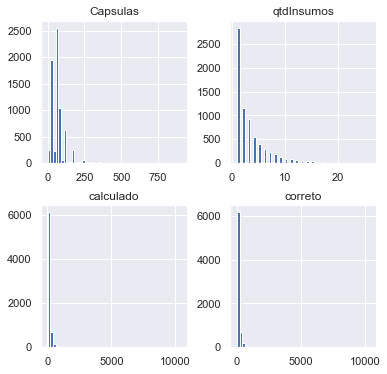

In [38]:
df.hist(figsize=(6, 6), bins=50)
plt.show()

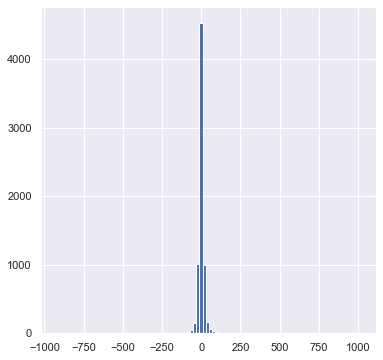

In [39]:
(df['correto'] - df['calculado']).hist(bins=100, figsize=(6, 6))
plt.show()

O violinplot é um gráfico interessante, ele mostra a densidade da distribuição dos dados combinando com um boxplot, trazendo informações sobre os quartis e outliers. No gráfico a baixo fica evidente uma considerável quantidade de outliers na quantidade de capsulas de cada pedido.

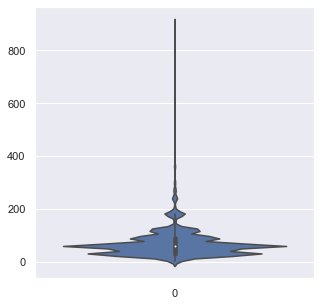

In [40]:
plt.figure(figsize=(5, 5))
sns.violinplot(data=df['Capsulas'])
plt.show()

A fim de curiosidade, fiz a correlação dos dados que possuiam quantidade de capsulas superior a 250 e logo a baixo de todos os dados da nossa coleção.
É interessante ver que a correlação entre a quantidade de capsulas e a nossa variável dependente 'correto', é maior quando analisados os dados que possuem uma maior quantidade de capsulas. Porém no modelo de ML projetado aqui, essa informação não foi considerada.

In [41]:
df.query('Capsulas > 250').corr()

,Capsulas,qtdInsumos,calculado,correto
Capsulas,1.000000,-0.027669,0.411403,0.485938
qtdInsumos,-0.027669,1.000000,0.171529,0.173147
calculado,0.411403,0.171529,1.000000,0.985132
correto,0.485938,0.173147,0.985132,1.000000


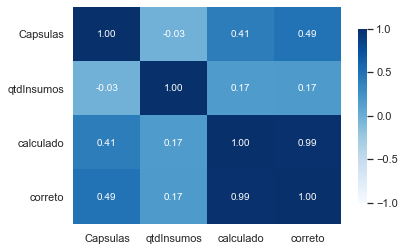

In [42]:
corr = df.query('Capsulas > 250').corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.show()

In [43]:
df.corr()

,Capsulas,qtdInsumos,calculado,correto
Capsulas,1.000000,-0.053763,0.225080,0.230430
qtdInsumos,-0.053763,1.000000,0.232302,0.254238
calculado,0.225080,0.232302,1.000000,0.982201
correto,0.230430,0.254238,0.982201,1.000000


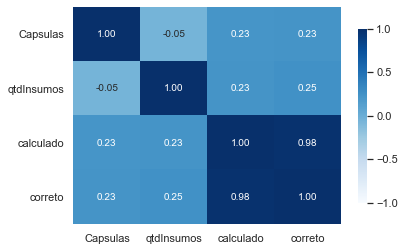

In [44]:
corr = df.corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.show()

# Dividindo os Dados

A partir desse ponto os dados serão preparados para serem utilizados nos modelos de ML abordados.
X são todos os dados independentes ou seja, aqueles que serão usados para fazer a predição, nesse caso usarei todas as variáveis menos 'Medicacao' e 'descricao'.
y é o que quero prever, a proposta pede para que os dados de 'correto'sejam previstos.

In [45]:
X = df.drop(['Medicacao','descricao', 'criado', 'correto'], axis=1)
y = df['correto']

Os dados serão divididos em treino e teste, treino é utilizado para treinar o modelo de predição e teste é utilizado para validar o nosso modelo criado, saber o quanto ele é bom em prever os resultados desejados.

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2808594298553574, random_state=19)

A partir desse ponto os modelos de Machine Learning serão criados, todos foram escritos seguindo a mesma estrutura para facilitar a compreensão e manter uma estrutura uniforme do projeto.

# Linear Regression

Pipeline é uma forma inteligente de criar um modelo de predição, ele previne o vazamento de informações no momento do treinamento do modelo e utilizarei essa técnica aqui. Ela recebe uma lista de tuplas, com o nome e a função, obedecendo uma ordem que representa as etapas no Pipeline.

In [47]:
steps = [('sc', StandardScaler()), ('lr', LinearRegression())]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

Para sanar a curiosidade, criei um DataFrame com os valores de 'correto' e os valores 'previsto's e a diferença entre os dois.

In [48]:
pd.DataFrame(data={'correto': y_test.values, 'previsto': y_pred, 'diferenca correto-previsto': y_test.values-y_pred})

,correto,previsto,diferenca correto-previsto
0,81.0,84.179471,-3.179471
1,179.0,162.154185,16.845815
2,132.2,140.091971,-7.891971
3,182.2,189.521613,-7.321613
4,94.0,103.913852,-9.913852
...,...,...,...
1995,164.0,170.862216,-6.862216
1996,69.4,82.553330,-13.153330
1997,195.5,208.277910,-12.777910
1998,528.3,551.953556,-23.653556


Para validar os modelos as métricas utilizadas foram R2, Mean Absolute Error(MAE), Mean Squared Error(MSE) e Root Mean Squared Error(RMSE). R2 representa o quanto que nosso modelo se assemelha dos dados reais, o valor vai de 0 a 1 e quanto mais próximo de 1, melhor o modelo, as outras tres médias são baseadas no erro entre o predito e o real, porém para fins de compreensão RMSE e MAE são mais fáceis pois são da mesma unidade dos valores preditos, quanto mais próximos de zero melhor o modelo, porém essa percepção pode variar de acordo com a proposta do modelo.

In [49]:
r2_score = metrics.r2_score(y_test, y_pred)
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)
df_lr = pd.DataFrame(data={'R2': r2_score, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}, index=["Linear Regression"])
df_lr

,R2,MAE,MSE,RMSE
Linear Regression,0.948212,13.211999,1101.961178,33.195801


O gráfico a baixo representa a curva dos 100 primeiros valores reais e dos valores preditos, possibilitando a visualização do quão bem os valores preditos se encaixam em relação aos originais.

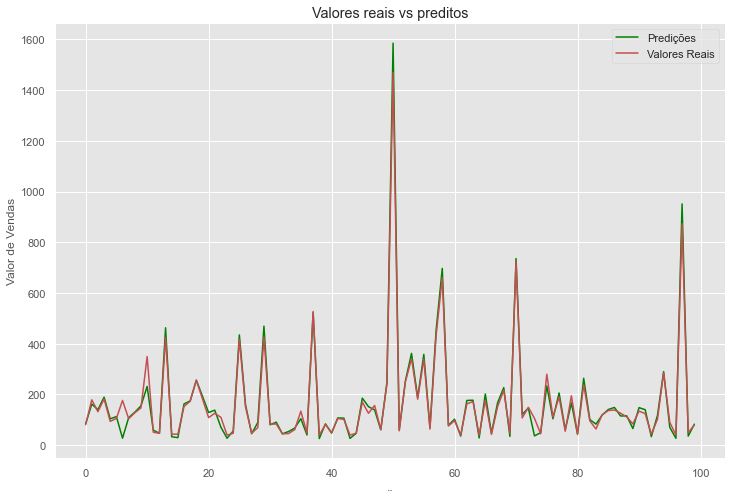

In [50]:
pred_lr = pd.DataFrame(y_pred[:100])
y_teste2 = pd.DataFrame(y_test.values[:100])
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.xlabel('..')
plt.ylabel('Valor de Vendas')
plt.title('Valores reais vs preditos')

plt.plot(pred_lr, c='green')
plt.plot(y_teste2, c='r')

plt.legend(['Predições','Valores Reais'])
plt.show()

# Random Forest

In [51]:
steps = [('sc', StandardScaler()), ('rf', RandomForestRegressor(n_estimators=50, random_state=19))]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [52]:
pd.DataFrame(data={'correto': y_test.values, 'previsto': y_pred, 'diferenca correto-previsto': y_test.values-y_pred})

,correto,previsto,diferenca correto-previsto
0,81.0,76.670000,4.330000
1,179.0,153.812000,25.188000
2,132.2,134.872000,-2.672000
3,182.2,177.478000,4.722000
4,94.0,102.732000,-8.732000
...,...,...,...
1995,164.0,165.714000,-1.714000
1996,69.4,81.963267,-12.563267
1997,195.5,204.664267,-9.164267
1998,528.3,566.992800,-38.692800


In [53]:
r2_score = metrics.r2_score(y_test, y_pred)
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)
df_rf = pd.DataFrame(data={'R2': r2_score, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}, index=["Random Forest"])
df_rf

,R2,MAE,MSE,RMSE
Random Forest,0.91521,12.352327,1804.200189,42.475878


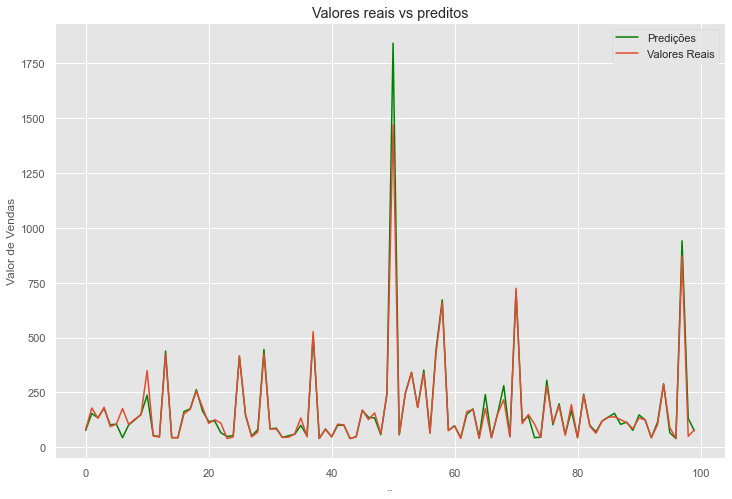

In [54]:
pred_rf = pd.DataFrame(y_pred[:100])
y_teste2 = pd.DataFrame(y_test.values[:100])
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.xlabel('..')
plt.ylabel('Valor de Vendas')
plt.title('Valores reais vs preditos')

plt_rforest = plt.plot(pred_rf, c='green')
plt.plot(y_teste2)

plt.legend(['Predições','Valores Reais'])
plt.show()

# Suport Vector Regressor

In [55]:
steps = [('sc', StandardScaler()), ('svr', SVR(kernel='linear'))]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [56]:
pd.DataFrame(data={'correto': y_test.values, 'previsto': y_pred, 'diferenca correto-previsto': y_test.values-y_pred})

,correto,previsto,diferenca correto-previsto
0,81.0,82.785305,-1.785305
1,179.0,156.115406,22.884594
2,132.2,136.010148,-3.810148
3,182.2,181.602061,0.597939
4,94.0,100.865929,-6.865929
...,...,...,...
1995,164.0,164.457382,-0.457382
1996,69.4,77.940969,-8.540969
1997,195.5,200.571578,-5.071578
1998,528.3,521.787013,6.512987


In [57]:
r2_score = metrics.r2_score(y_test, y_pred)
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)
df_svr = pd.DataFrame(data={'R2': r2_score, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}, index=['SVR'])
df_svr

,R2,MAE,MSE,RMSE
SVR,0.950073,11.368167,1062.374186,32.594082


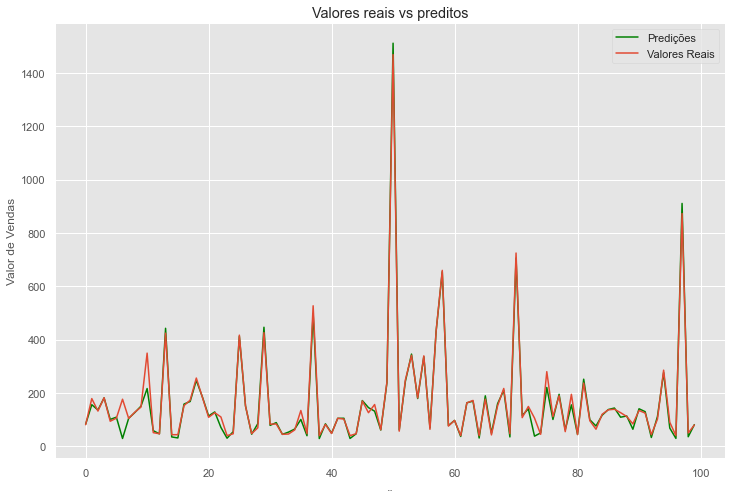

In [58]:
pred_svr = pd.DataFrame(y_pred[:100])
y_teste2 = pd.DataFrame(y_test.values[:100])
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.xlabel('..')
plt.ylabel('Valor de Vendas')
plt.title('Valores reais vs preditos')

plt.plot(pred_svr, c='green')
plt.plot(y_teste2)

plt.legend(['Predições','Valores Reais'])
plt.show()

# Gradient Boosting

In [59]:
steps = [('sc', StandardScaler()), ('gbr', GradientBoostingRegressor(random_state=19))]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [60]:
pd.DataFrame(data={'correto': y_test.values, 'previsto': y_pred, 'diferenca correto-previsto': y_test.values-y_pred})

,correto,previsto,diferenca correto-previsto
0,81.0,77.605141,3.394859
1,179.0,154.624658,24.375342
2,132.2,132.512388,-0.312388
3,182.2,184.558761,-2.358761
4,94.0,102.572297,-8.572297
...,...,...,...
1995,164.0,166.947828,-2.947828
1996,69.4,76.196829,-6.796829
1997,195.5,207.999155,-12.499155
1998,528.3,580.593413,-52.293413


In [61]:
r2_score = metrics.r2_score(y_test, y_pred)
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)
df_gboost = pd.DataFrame(data={'R2': r2_score, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}, index=['GBoost'])
df_gboost

,R2,MAE,MSE,RMSE
GBoost,0.941152,11.324039,1252.200227,35.386441


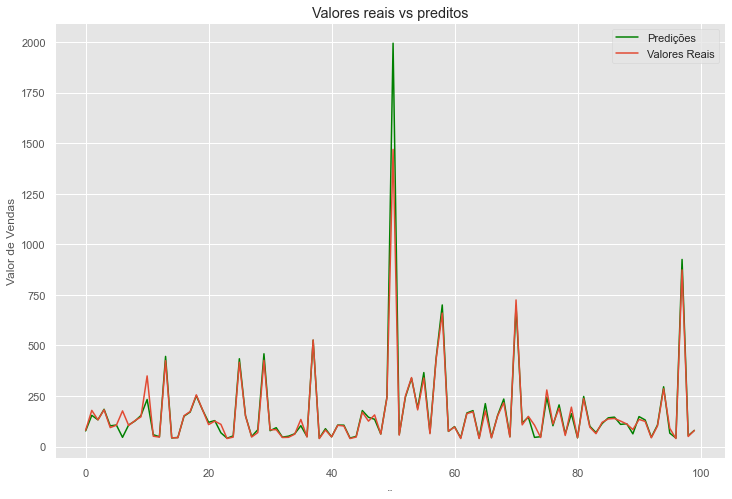

In [62]:
pred_gb = pd.DataFrame(y_pred[:100])
y_teste2 = pd.DataFrame(y_test.values[:100])
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.xlabel('..')
plt.ylabel('Valor de Vendas')
plt.title('Valores reais vs preditos')

plt.plot(pred_gb, c='green')
plt.plot(y_teste2)

plt.legend(['Predições','Valores Reais'])
plt.show()

# Conclusão

In [64]:
df_metricas = pd.concat([df_lr, df_rf, df_svr, df_gboost])
df_metricas

,R2,MAE,MSE,RMSE
Linear Regression,0.948212,13.211999,1101.961178,33.195801
Random Forest,0.915210,12.352327,1804.200189,42.475878
SVR,0.950073,11.368167,1062.374186,32.594082
GBoost,0.941152,11.324039,1252.200227,35.386441


Comparando os resultados obtidos entre os 4 modelos selecionados, o que teve o melhor resultado foi o <b>SVR</b>
com um R2 de 0.95, MAE de 11.36, MSE de 1062.37 e RMSE de 32.59.